## 4.2 線形回帰

In [29]:
import scipy
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt

# Make the simulation data
size_cluster = 300
mat_cov = scipy.eye(2)
cluster1 = scipy.random.multivariate_normal([-4, -4], mat_cov, size_cluster)
cluster2 = scipy.random.multivariate_normal([0, 0], mat_cov, size_cluster)
cluster3 = scipy.random.multivariate_normal([4, 4], mat_cov, size_cluster)
target1, target2, target3 = scipy.eye(3)
# print(target1, target2, target3, type(target1))
mat_x0 = scipy.concatenate((cluster1, cluster2, cluster3))
mat_x = scipy.hstack((scipy.ones((size_cluster*3, 1)), mat_x0))
mat_y = scipy.vstack((scipy.tile(target1, (size_cluster, 1)),
                      scipy.tile(target2, (size_cluster, 1)),
                      scipy.tile(target3, (size_cluster, 1))))
# print(mat_x, mat_x.shape)
# print(mat_y, mat_y.shape)

# Multiple linear regression
mat_beta = scipy.linalg.solve(mat_x.T @ mat_x, mat_x.T @ mat_y)
mat_y_hat = mat_x @ mat_beta
assert scipy.allclose(mat_y_hat.sum(axis=1), 1)
# print(mat_y_hat)
idx_classified_y = mat_y_hat.argmax(axis=1)
# print(idx_classified_y, idx_classified_y.size)

classified_cluster1 = mat_x0[idx_classified_y == 0]
classified_cluster2 = mat_x0[idx_classified_y == 1]
classified_cluster3 = mat_x0[idx_classified_y == 2]

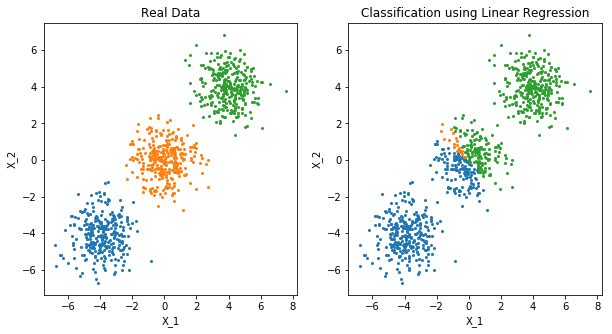

In [30]:
fig42 = plt.figure(0, figsize=(10, 5))
ax1 = fig42.add_subplot(1, 2, 1)
ax1.plot(cluster1[:,0], cluster1[:,1], 'o', color='C0', markersize=2)
ax1.plot(cluster2[:,0], cluster2[:,1], 'o', color='C1', markersize=2)
ax1.plot(cluster3[:,0], cluster3[:,1], 'o', color='C2', markersize=2)
ax1.set_xlabel('X_1')
ax1.set_ylabel('X_2')
ax1.set_title('Real Data')

ax2 = fig42.add_subplot(1, 2, 2)
ax2.plot(classified_cluster1[:,0], classified_cluster1[:,1], 'o', color='C0', markersize=2)
ax2.plot(classified_cluster2[:,0], classified_cluster2[:,1], 'o', color='C1', markersize=2)
ax2.plot(classified_cluster3[:,0], classified_cluster3[:,1], 'o', color='C2', markersize=2)
ax2.set_xlabel('X_1')
ax2.set_ylabel('X_2')
ax2.set_title('Classification using Linear Regression')
plt.show()

## 4.3 LDA

In [31]:
# Estimating parameters
vec_mean1 = cluster1.mean(axis=0)
vec_mean2 = cluster2.mean(axis=0)
vec_mean3 = cluster3.mean(axis=0)

cluster_centered1 = cluster1 - vec_mean1
cluster_centered2 = cluster2 - vec_mean2
cluster_centered3 = cluster3 - vec_mean3
mat_cov = (cluster_centered1.T @ cluster_centered1 +
           cluster_centered2.T @ cluster_centered2 +
           cluster_centered3.T @ cluster_centered3)/(3*size_cluster-3)

In [32]:
# Calculate linear discriminant scores
sigma_inv_mu123 = scipy.linalg.solve(
    mat_cov,
    scipy.vstack((vec_mean1, vec_mean2, vec_mean3)).T,
)
sigma_inv_mu1, sigma_inv_mu2, sigma_inv_mu3 = sigma_inv_mu123.T

mat_x = scipy.vstack((cluster1, cluster2, cluster3))
mat_delta = (mat_x @ sigma_inv_mu123 -
             scipy.array((vec_mean1 @ sigma_inv_mu1,
                          vec_mean2 @ sigma_inv_mu2,
                          vec_mean3 @ sigma_inv_mu3))/2)

cluster_classified1 = mat_x[mat_delta.argmax(axis=1) == 0]
cluster_classified2 = mat_x[mat_delta.argmax(axis=1) == 1]
cluster_classified3 = mat_x[mat_delta.argmax(axis=1) == 2]

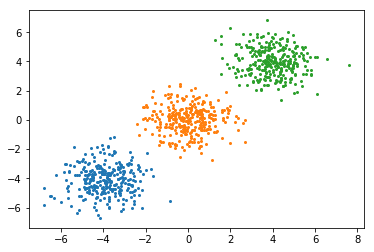

In [34]:
plt.plot(cluster_classified1[:,0], cluster_classified1[:,1], 'o', color='C0', markersize=2)
plt.plot(cluster_classified2[:,0], cluster_classified2[:,1], 'o', color='C1', markersize=2)
plt.plot(cluster_classified3[:,0], cluster_classified3[:,1], 'o', color='C2', markersize=2)

plt.show()

## 4.4 Logistic Regression
### 4.4.2 South African Heart Disease